# Transfer Learning with TensorFlow Part 1: Feature Extraction


#Downloading the data

In [1]:
# Get data(10% of food classes)
import zipfile

In [2]:
# Download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()


--2023-04-18 10:26:42--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.119.128, 108.177.126.128, 108.177.127.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.119.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  41.0MB/s    in 4.6s    

2023-04-18 10:26:47 (35.1 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [5]:
# How many images in each folder?
import os
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are{len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are2 directories and 0 images in '10_food_classes_10_percent'.
There are10 directories and 0 images in '10_food_classes_10_percent/test'.
There are0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'

# Creating data loades (preparing the data

In [47]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (244,244)
BATCH_SIZE = (32)
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale = 1/255.)
test_datagen = ImageDataGenerator(rescale = 1/255.)


print("Training images: ")
train_data_10_percent = train_datagen.flow_from_directory(
    train_dir,
    target_size = IMAGE_SHAPE,
    batch_size = BATCH_SIZE,
    class_mode = "categorical"
)

print("Test images: ")
test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size = IMAGE_SHAPE,
    batch_size = BATCH_SIZE,
    class_mode = "categorical"  
)

Training images: 
Found 750 images belonging to 10 classes.
Test images: 
Found 2500 images belonging to 10 classes.


# Setting up Callbacks

In [41]:
# Create tensorboard callback (functionized because need to create a new one for each model)
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback
     

# Creating models using TensorFlow Hub


In [23]:
# URL of the pretained models
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

In [43]:
# Import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.layers import Dense, Flatten,  MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import TensorBoard


In [37]:
# Create model
def create_model(model_url, num_classes=10):
  """ 
  Takes a Tensorflow Hub URL and creates a kers Sequential model with it.

  Args:
    model_url (str): Tensorflow hUB FEATURES EXTRACTION url
    num_classes (int): Number of output neurons in th output layes,
    should be equal to number of target classes, default 10.
  
  Returns:
  An uncompiled Keras Sequential model with model_url as fetures extractor
  layer and Dense output layer with num_classes output.

  """

  # Donload the pretrained model and save it as a Keras Layer
  feature_extraction_layer = hub.KerasLayer(model_url,
                                            trainable=False,
                                            name="feature_extraction_layer",
                                            input_shape=IMAGE_SHAPE+(3,))

 #Create our sequential model
  model = tf.keras.Sequential([
      feature_extraction_layer,
      layers.Dense(num_classes, activation="softmax", name = "output")
  ])
  return model

# Creating ResNet Tensorflow Hub Extrction model


In [49]:
# Create Resnet Model
resnet_model = create_model(
    resnet_url,
     num_classes = train_data_10_percent.num_classes)
resnet_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output (Dense)              (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [50]:
# Compile the model
resnet_model.compile(loss = "categorical_crossentropy",
               optimizer = Adam(),
               metrics = ["accuracy"])

In [51]:
# Fit the model
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  # Add TensorBoard callback to model (callbacks parameter takes a list)
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", # save experiment logs here
                                                                         experiment_name="resnet50V2")]) # name of log files


Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20230418-112500
Epoch 1/5
24/24 [==============================] - 35s 906ms/step - loss: 1.9128 - accuracy: 0.3507 - val_loss: 1.1907 - val_accuracy: 0.6408
Epoch 2/5
24/24 [==============================] - 25s 1s/step - loss: 0.9283 - accuracy: 0.7387 - val_loss: 0.8546 - val_accuracy: 0.7364
Epoch 3/5
24/24 [==============================] - 25s 1s/step - loss: 0.6339 - accuracy: 0.8227 - val_loss: 0.7135 - val_accuracy: 0.7836
Epoch 4/5
24/24 [==============================] - 19s 801ms/step - loss: 0.4877 - accuracy: 0.8867 - val_loss: 0.6602 - val_accuracy: 0.8008
Epoch 5/5
24/24 [==============================] - 18s 782ms/step - loss: 0.3933 - accuracy: 0.9200 - val_loss: 0.6294 - val_accuracy: 0.8032


In [52]:
# Plot loss curves
# Tidbit: you can put a function like this into a script called "helper.py" and import it
import matplotlib.pyplot as plt

# Plot the validation and training curves
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();
     


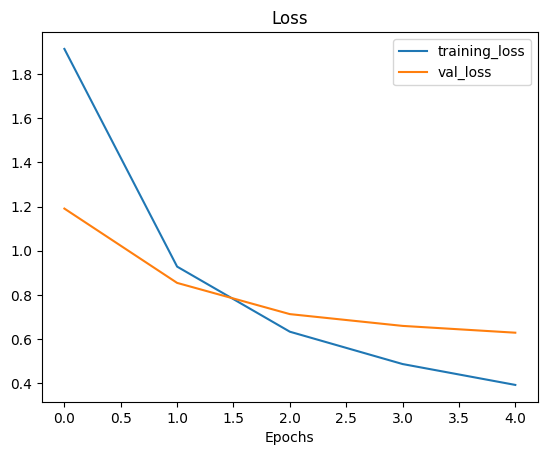

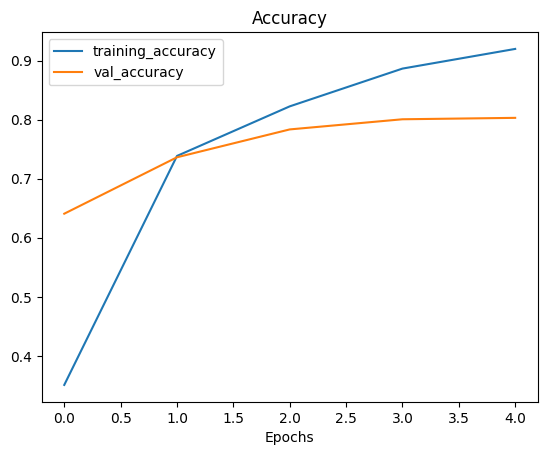

In [54]:
plot_loss_curves(resnet_history)

In [56]:
resnet_model.layers[0].weights

[<tf.Variable 'resnet_v2_50/block2/unit_2/bottleneck_v2/conv3/weights:0' shape=(1, 1, 128, 512) dtype=float32, numpy=
 array([[[[ 0.002027  ,  0.00017163,  0.01592856, ..., -0.05126907,
           -0.0172796 ,  0.0653937 ],
          [ 0.02668411,  0.00581701, -0.03393495, ..., -0.02481808,
            0.02091978, -0.05294194],
          [-0.04577746,  0.00164415, -0.02405027, ..., -0.00264602,
           -0.078317  ,  0.03324007],
          ...,
          [ 0.01922877,  0.00851064, -0.010778  , ..., -0.01534228,
           -0.0241753 ,  0.03973923],
          [ 0.00835421, -0.01399965,  0.02992119, ...,  0.02500054,
            0.01324084, -0.02472028],
          [-0.00661634,  0.00861663,  0.01429743, ...,  0.03899445,
           -0.00041185, -0.03232638]]]], dtype=float32)>,
 <tf.Variable 'resnet_v2_50/block1/unit_2/bottleneck_v2/conv1/weights:0' shape=(1, 1, 256, 64) dtype=float32, numpy=
 array([[[[-0.01411932,  0.02409191,  0.00857928, ..., -0.05003903,
           -0.00112336, -0

In [57]:
# Upload tensorboard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "Resnet" \
  --description "Visualize the pretrained model" \
  --one_shot

2023-04-18 11:47:00.385097: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

To sign in with the TensorBoard uploader:

1. On your computer or phone, visit:

   https://www.google.com/device

2. Sign in with your Google account, then enter:

   VLKN-NJWW



New experiment created. View your TensorBoard at: https://tensorboard.dev/expe

In [58]:
# Check out what Tensorboard experiments you have
!tensorboard dev list

2023-04-18 11:51:12.833034: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
https://tensorboard.dev/experiment/0szLHoeLQ4WarjSYJLQv1A/
	Name                 Resnet
	Description          Visualize the pretrained model
	Id                   0szLHoeLQ4WarjSYJLQv1A
	Created              2023-04-18 11:48:08 (3 minutes ago)
	Updated              2023-04-18 11:48:09 (3 minutes ago)
	Runs                 2
	Tags                 5
	Scalars              30
	Tensor bytes         0
	Binary object bytes  1851045
Total: 1 experiment(s)


In [ ]:
# Delate experiment
#!tensorboard dev delete --experiment_id 0szLHoeLQ4WarjSYJLQv1A